In [1]:
import requests

url = 'http://httpbin.org/get'
a1 = requests.get(url)
s1 = a1.text


In [2]:
s1

'{\n  "args": {}, \n  "headers": {\n    "Accept": "*/*", \n    "Accept-Encoding": "gzip, deflate", \n    "Connection": "close", \n    "Host": "httpbin.org", \n    "User-Agent": "python-requests/2.12.4"\n  }, \n  "origin": "218.197.248.52", \n  "url": "http://httpbin.org/get"\n}\n'

In [3]:
headers = {
    'user_agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'
}

In [4]:
a2 = requests.get(url,headers=headers)

In [5]:
a2.status_code

200

In [15]:
s2 = a2.text

In [8]:
url2 = 'http://httpbin.org/post'
a3 = requests.get(url2)


In [16]:
s2

'{\n  "args": {}, \n  "headers": {\n    "Accept": "*/*", \n    "Accept-Encoding": "gzip, deflate", \n    "Connection": "close", \n    "Host": "httpbin.org", \n    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36"\n  }, \n  "origin": "218.197.248.52", \n  "url": "http://httpbin.org/get"\n}\n'

In [9]:
a3.status_code

405

In [10]:
data ={
    'python':39,
    39:'python'
}

In [11]:
a4 = requests.post(url2,data=data)

In [12]:
a4.status_code


200

# Setup

In [1]:
import numpy as np
import os 
import sys

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12



In [2]:
sys.platform

'win32'

In [2]:
def plot_image(image,shape=[28,28]):
    plt.imshow(image.reshape(shape),cmap='Greys',interpolation='nearest')
    plt.axis('off')

In [25]:
def plot_multiple_image(images,n_rows,n_cols,pad=2):
    images = images - images.min()
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad,(h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)]= images[y*n_cols+x]
    plt.imshow(image,cmap='Greys',interpolation='nearest')
    plt.axis('off')

# PCA with a linear Autoencoder

In [16]:
np.random.seed(42)
m = 200
w1 , w2 = 0.1,0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m,3))
data[:,0] = np.cos(angles) + np.sin(angles)/2 + 0.5 * noise * np.random.randn(m)
data[:,1] = np.sin(angles) * 0.7 + noise * np.random.randn(m)/ 2
data[:,2] = data[:,0] * w1 + data[:,1] * w2 + noise * np.random.randn(m) 

In [13]:
np.random.randn(200).shape,np.random.rand(200).shape

((200,), (200,))

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])


In [18]:
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32,shape=[None,n_inputs])
hidden = tf.layers.dense(X,n_hidden)
outputs = tf.layers.dense(hidden,n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [19]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train})
    codings_val = codings.eval(feed_dict={X:X_test})
    

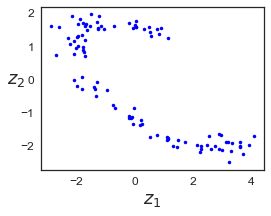

In [22]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0],codings_val[:,1],'b.')
plt.xlabel('$z_1$',fontsize=18)
plt.ylabel('$z_2$',fontsize=18,rotation=0)
plt.show()

In [23]:
codings_val.shape

(100, 2)

# Stacked Autoencoders

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('E:/python_work/handson_ml/datasets')

Extracting E:/python_work/handson_ml/datasets\train-images-idx3-ubyte.gz
Extracting E:/python_work/handson_ml/datasets\train-labels-idx1-ubyte.gz
Extracting E:/python_work/handson_ml/datasets\t10k-images-idx3-ubyte.gz
Extracting E:/python_work/handson_ml/datasets\t10k-labels-idx1-ubyte.gz


In [27]:
reset_graph()

from functools import partial

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32,shape=[None,n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()


l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation = tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer= l2_regularizer 
                         )
hidden1 = my_dense_layer(X,n_hidden1)
hidden2 = my_dense_layer(hidden1,n_hidden2)
hidden3 = my_dense_layer(hidden2,n_hidden3)
outputs = my_dense_layer(hidden3,n_outputs,activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))

reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_loss)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()



In [28]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print('\r{}%'.format(100*iteration//n_batches),end='')
            sys.stdout.flush()
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print('\r{}'.format(epoch),'Train MSE:',loss_train)
        saver.save(sess,'E:/python_work/handson_ml/tf_logs/run_20170929/my_model.ckpt')

0 Train MSE: 0.0208554
1 Train MSE: 0.0113726
2 Train MSE: 0.0102246
3 Train MSE: 0.00990046
4 Train MSE: 0.0103758
5 Train MSE: 0.010986
6 Train MSE: 0.0108095
7 Train MSE: 0.01118
8 Train MSE: 0.0120165
9 Train MSE: 0.0124567


In [5]:
def show_reconstructed_digits(X,outputs,model_path=None,n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess,model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X:X_test})
        
    fig = plt.figure(figsize=(8,3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits,2,digit_index*2+1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits,2,digit_index*2+2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170929/my_model.ckpt


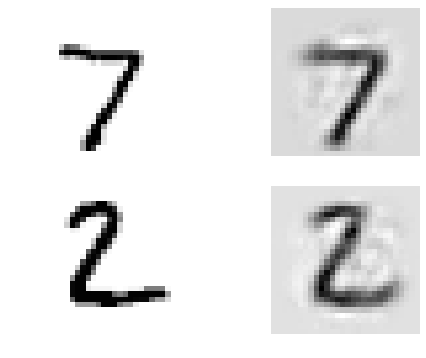

In [32]:
show_reconstructed_digits(X,outputs,'E:/python_work/handson_ml/tf_logs/run_20170929/my_model.ckpt')

# Tying weights

In [33]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_ouputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005




In [37]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32,shape=[None,n_inputs])

weights1_init = initializer([n_inputs,n_hidden1])
weights2_init = initializer([n_hidden1,n_hidden2])

weights1 = tf.Variable(weights1_init,dtype=tf.float32,name='weights1')
weights2 = tf.Variable(weights2_init,dtype=tf.float32,name='weights2')
weights3 = tf.transpose(weights2,name='weights3')
weights4 = tf.transpose(weights1,name='weights4')

biases1 = tf.Variable(tf.zeros(n_hidden1),name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2),name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3),name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs),name='biases4')

hidden1 = activation(tf.matmul(X,weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1,weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2,weights3) + biases3)
outputs = tf.matmul(hidden3,weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [39]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print('\r{}%'.format(100 * iteration //n_batches),end='')
            sys.stdout.flush()
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print('\r{}'.format(epoch),'Train MSE: ', loss_train)
        saver.save(sess,'E:/python_work/handson_ml/tf_logs/run_20170929_2/my_model.ckpt')

0 Train MSE:  0.0175016
1 Train MSE:  0.0163492
2 Train MSE:  0.0161492
3 Train MSE:  0.0167934
4 Train MSE:  0.0178975
5 Train MSE:  0.0174331
6 Train MSE:  0.0168225
7 Train MSE:  0.0176591
8 Train MSE:  0.017609
9 Train MSE:  0.0176935


INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170929_2/my_model.ckpt


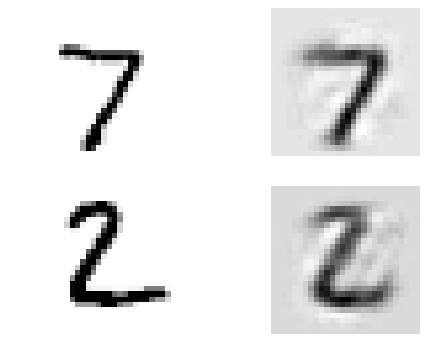

In [40]:

show_reconstructed_digits(X, outputs, "E:/python_work/handson_ml/tf_logs/run_20170929_2/my_model.ckpt")

# Training one Autoencoder at a tim in multiple graphs

In [64]:
reset_graph()

from functools import partial

def train_autoencoder(X_train,n_neurons,n_epochs,batch_size,
                      learning_rate=0.01,l2_reg = 0.0005,
                      activation=tf.nn.elu,seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)
        n_inputs = X_train.shape[1]
        X = tf.placeholder(tf.float32,shape=[None,n_inputs])
        
        my_dense_layer = partial(
        tf.layers.dense,
        activation= activation,
        kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
        kernel_regularizer = tf.contrib.layers.l2_regularizer(l2_reg))
        
        hidden = my_dense_layer(X,n_neurons,name='hidden')
        outputs = my_dense_layer(hidden,n_inputs,activation=None,name='outputs')
        
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
        
        reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_loss)
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
        
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print('\r{}%'.format(100*iteration//n_batches),end='')
                sys.stdout.flush()
                indices = np.random.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op,feed_dict={X:X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
            print('\r{}'.format(epoch),'Train MSE:',loss_train)
        params = dict([(var.name,var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X:X_batch})
        return hidden_val,params['hidden/kernel:0'],params['hidden/bias:0'],params['outputs/kernel:0'],params['outputs/bias:0']

In [65]:

hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.0189755
1 Train MSE: 0.0185663
2 Train MSE: 0.0183356
3 Train MSE: 0.0189602
0 Train MSE: 0.264954
1 Train MSE: 0.161168
2 Train MSE: 0.115582
3 Train MSE: 0.0918051


In [66]:
hidden_output

array([[ 0.46827376,  0.08612435,  2.08054018, ...,  0.17500676,
        -0.04091907,  2.9765799 ],
       [-0.19646215, -0.21826673, -0.01248008, ...,  0.03025155,
         0.10662742,  0.10624391],
       [-0.15582335, -0.01792401,  0.60693502, ..., -0.08876008,
         0.08757721,  0.75704384],
       ..., 
       [ 0.07426524,  0.08069791,  0.31328475, ...,  0.13874649,
        -0.02671874,  0.20972055],
       [-0.0698452 , -0.07613778, -0.05468875, ..., -0.13038707,
         0.03985507,  0.11438948],
       [ 0.08501717, -0.14673638,  0.34085125, ...,  0.38365334,
        -0.18382221,  0.58796144]], dtype=float32)

In [67]:
reset_graph()

n_inputs = 28 * 28

X = tf.placeholder(tf.float32,shape=[None,n_inputs])

hidden1 = tf.nn.elu(tf.matmul(X,W1)+b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1,W2)+b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2,W3)+b3)
outputs = tf.matmul(hidden3,W4) +b4



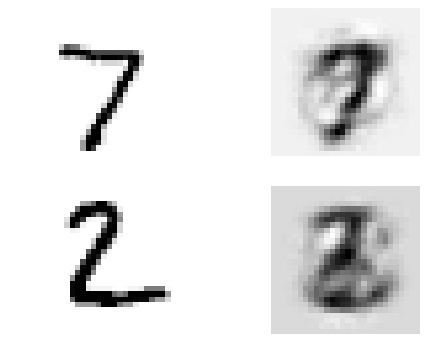

In [69]:
show_reconstructed_digits(X,outputs)

# Training one Autoencoder at a time in a single graph

In [70]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [71]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [72]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [73]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "E:/python_work/handson_ml/tf_logs/run_20170929_3/my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.0076224
19% Train MSE: 0.00725095
2 Train MSE: 0.00783793
3 Train MSE: 0.00824736
Training phase #2
0 Train MSE: 0.29616
1 Train MSE: 0.00836937
2 Train MSE: 0.00300439
3 Train MSE: 0.00221475
Test MSE: 0.00976427


# Cache the frozen layer outputs

In [74]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = np.random.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "E:/python_work/handson_ml/tf_logs/run_20170929_4/my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.00775532
1 Train MSE: 0.00756871
2 Train MSE: 0.0080059
3 Train MSE: 0.0078918
Training phase #2
0 Train MSE: 0.0650064
1 Train MSE: 0.00536262
2 Train MSE: 0.00256693
39% Train MSE: 0.0021392
Test MSE: 0.00970105


INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170929_3/my_model_one_at_a_time.ckpt


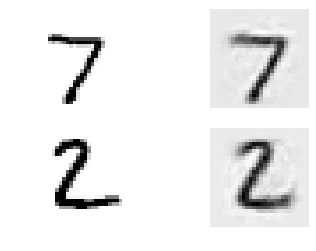

In [75]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "E:/python_work/handson_ml/tf_logs/run_20170929_3/my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170929_3/my_model_one_at_a_time.ckpt


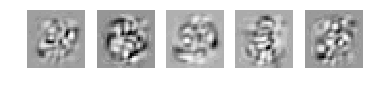

In [76]:
with tf.Session() as sess:
    saver.restore(sess, "E:/python_work/handson_ml/tf_logs/run_20170929_3/my_model_one_at_a_time.ckpt") # not shown in the book
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])
    
plt.show()

# Unsupervised pretraining

In [77]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [78]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = np.random.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "E:/python_work/handson_ml/tf_logs/run_20170929_5/my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.913333 Test accuracy: 0.9215
1 Train accuracy: 0.966667 Test accuracy: 0.9404
2 Train accuracy: 0.973333 Test accuracy: 0.9507
3 Train accuracy: 0.973333 Test accuracy: 0.9464


In [80]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "E:/python_work/handson_ml/tf_logs/run_20170929_4/my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = np.random.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "E:/python_work/handson_ml/tf_logs/run_20170929_6/my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)
        

INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170929_4/my_model_cache_frozen.ckpt
0 Train accuracy: 0.933333	Test accuracy: 0.9333
1 Train accuracy: 0.96	Test accuracy: 0.9342
2 Train accuracy: 0.953333	Test accuracy: 0.9245
3 Train accuracy: 0.966667	Test accuracy: 0.9478


# Stacked denoising Autoencoder

In [81]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [82]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [83]:

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [84]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "E:/python_work/handson_ml/tf_logs/run_20170929_7/my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.0429008
1 Train MSE: 0.0425173
2 Train MSE: 0.0419403
3 Train MSE: 0.0413947
4 Train MSE: 0.0424495
5 Train MSE: 0.0413562
6 Train MSE: 0.0397677
7 Train MSE: 0.0420645
8 Train MSE: 0.0433838
9 Train MSE: 0.0421968


Using dropout:

In [85]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [86]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [87]:

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [88]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "E:/python_work/handson_ml/tf_logs/run_20170929_8/my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.0347836
1 Train MSE: 0.0320789
2 Train MSE: 0.0291542
3 Train MSE: 0.0322753
4 Train MSE: 0.0295604
5 Train MSE: 0.0316486
6 Train MSE: 0.030232
7 Train MSE: 0.0305315
8 Train MSE: 0.0295478
9 Train MSE: 0.0305235


INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170929_8/my_model_stacked_denoising_dropout.ckpt


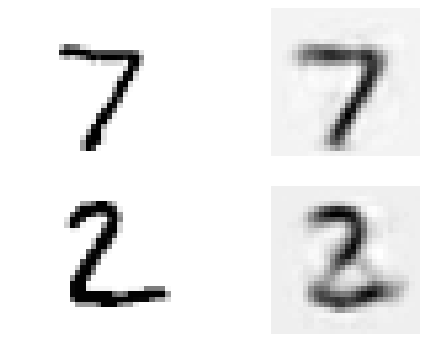

In [89]:
show_reconstructed_digits(X, outputs, "E:/python_work/handson_ml/tf_logs/run_20170929_8/my_model_stacked_denoising_dropout.ckpt")


# Sparse Autoencoder

[0, 1, 0, 0.95]

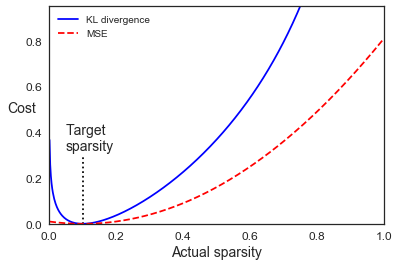

In [91]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])


In [92]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000
n_outputs = n_inputs


In [94]:
def kl_divergence(p,q):
    return p*tf.log(p/q) + (1-p) * tf.log((1-p)/(1-q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32,shape=[None,n_inputs])

hidden1 = tf.layers.dense(X,n_hidden1,activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1,n_outputs)

hidden1_mean = tf.reduce_mean(hidden1,axis=0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target,hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X ))
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op =optimizer.minimize(loss)

In [95]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [101]:
n_epochs = 50
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        reconstruction_loss_val , sparsity_loss_val ,loss_val = sess.run([
            reconstruction_loss,sparsity_loss,loss],feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess,'E:/python_work/handson_ml/tf_logs/run_20170929_9/my_model_sparse.ckpt')

0 Train MSE: 0.120326 	Sparsity loss: 1.12732 	Total loss: 0.345791
1 Train MSE: 0.0594781 	Sparsity loss: 0.205749 	Total loss: 0.100628
2 Train MSE: 0.0528083 	Sparsity loss: 0.01404 	Total loss: 0.0556163
3 Train MSE: 0.0477991 	Sparsity loss: 0.046798 	Total loss: 0.0571587
4 Train MSE: 0.0435448 	Sparsity loss: 0.050747 	Total loss: 0.0536942
5 Train MSE: 0.0403355 	Sparsity loss: 0.0898428 	Total loss: 0.058304
6 Train MSE: 0.0371417 	Sparsity loss: 0.109219 	Total loss: 0.0589855
7 Train MSE: 0.0342621 	Sparsity loss: 0.0905036 	Total loss: 0.0523628
8 Train MSE: 0.0318321 	Sparsity loss: 0.0608457 	Total loss: 0.0440013
9 Train MSE: 0.0282292 	Sparsity loss: 0.130242 	Total loss: 0.0542776
10 Train MSE: 0.0263042 	Sparsity loss: 0.0526854 	Total loss: 0.0368413
11 Train MSE: 0.0247307 	Sparsity loss: 0.227467 	Total loss: 0.070224
12 Train MSE: 0.0244073 	Sparsity loss: 0.174459 	Total loss: 0.0592991
13 Train MSE: 0.0226637 	Sparsity loss: 0.0324985 	Total loss: 0.0291634
14 T

INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170929_9/my_model_sparse.ckpt


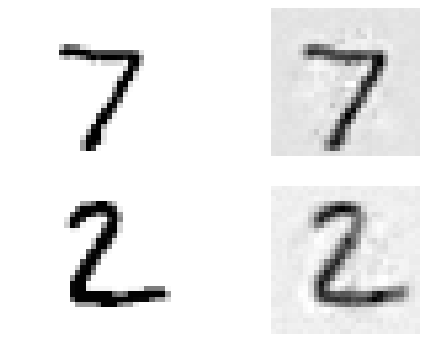

In [102]:

show_reconstructed_digits(X, outputs, "E:/python_work/handson_ml/tf_logs/run_20170929_9/my_model_sparse.ckpt")

# Variable Autoencoder

In [11]:
from functools import partial
import tensorflow as tf
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 300
n_hidden3 = 20
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
tf.layers.dense,activation=tf.nn.elu,
kernel_initializer= initializer)

X = tf.placeholder(tf.float32,shape=[None,n_inputs])
hidden1 = my_dense_layer(X,n_hidden1)
hidden2 = my_dense_layer(hidden1,n_hidden2)
hidden3_mean = my_dense_layer(hidden2,n_hidden3,activation=None)
hidden3_sigma = my_dense_layer(hidden2,n_hidden3,activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma),dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3,n_hidden4)
hidden5 = my_dense_layer(hidden4,n_hidden5)
logits = my_dense_layer(hidden5,n_outputs,activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X,logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [12]:
eps = 1e-10
laten_loss = 0.5 * tf.reduce_sum(
tf.square(hidden3_sigma) + tf.square(hidden3_mean)
- 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [13]:
loss = reconstruction_loss + laten_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
n_epochs = 50
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print('\r{}%'.format(100 * iteration//n_batches),end='')
            sys.stdout.flush()
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        loss_val,reconstruction_loss_val,laten_loss_val = sess.run([loss,
        reconstruction_loss,laten_loss],feed_dict={X:X_batch})
        print('\r{}'.format(epoch),'Train total loss:',loss_val,'\tReconstruction loss:',
             reconstruction_loss_val,'\t Laten loss: ',laten_loss_val)
        saver.save(sess,'E:/python_work/handson_ml/tf_logs/run_20170930/my_model_variational.ckpt')

09% Train total loss: 21735.5 	Reconstruction loss: 17213.6 	 Laten loss:  4521.93
1 Train total loss: 16919.0 	Reconstruction loss: 14183.7 	 Laten loss:  2735.25
2 Train total loss: 14935.2 	Reconstruction loss: 12906.1 	 Laten loss:  2029.09
3 Train total loss: 14916.7 	Reconstruction loss: 12873.2 	 Laten loss:  2043.55
4 Train total loss: 12462.8 	Reconstruction loss: 10623.9 	 Laten loss:  1838.93
5 Train total loss: 11455.7 	Reconstruction loss: 9629.36 	 Laten loss:  1826.31
6 Train total loss: 11599.7 	Reconstruction loss: 9672.2 	 Laten loss:  1927.53
7 Train total loss: 11808.1 	Reconstruction loss: 9800.28 	 Laten loss:  2007.86
8 Train total loss: 10569.2 	Reconstruction loss: 8656.46 	 Laten loss:  1912.73
9 Train total loss: 10606.4 	Reconstruction loss: 8686.41 	 Laten loss:  1919.98
10 Train total loss: 11040.4 	Reconstruction loss: 8951.04 	 Laten loss:  2089.31
11 Train total loss: 10297.9 	Reconstruction loss: 8326.18 	 Laten loss:  1971.69
12 Train total loss: 1968

In [18]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 300
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170930/my_model_variational.ckpt


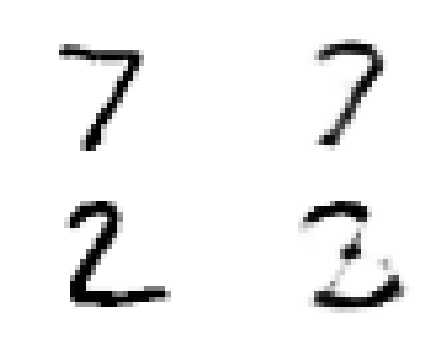

In [19]:
show_reconstructed_digits(X, outputs, "E:/python_work/handson_ml/tf_logs/run_20170930/my_model_variational.ckpt")

# Generate digits

In [20]:
n_digits = 60
n_epochs = 50
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range( n_batches):
            print('\r{}%'.format(100*iteration//n_batches),end='')
            sys.stdout.flush()
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "E:/python_work/handson_ml/tf_logs/run_20170930_2/my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 11694.2 	Reconstruction loss: 9185.2 	Latent loss: 2509.05
1 Train total loss: 11504.2 	Reconstruction loss: 9041.46 	Latent loss: 2462.73
2 Train total loss: 11080.1 	Reconstruction loss: 8548.24 	Latent loss: 2531.9
39% Train total loss: 10941.2 	Reconstruction loss: 8426.89 	Latent loss: 2514.34
4 Train total loss: 9987.72 	Reconstruction loss: 7542.27 	Latent loss: 2445.45
5 Train total loss: 10590.0 	Reconstruction loss: 8090.59 	Latent loss: 2499.4
69% Train total loss: 10941.9 	Reconstruction loss: 8302.11 	Latent loss: 2639.76
7 Train total loss: 10807.1 	Reconstruction loss: 8212.24 	Latent loss: 2594.82
8 Train total loss: 10936.4 	Reconstruction loss: 8325.91 	Latent loss: 2610.5
99% Train total loss: 10392.6 	Reconstruction loss: 7792.32 	Latent loss: 2600.25
10 Train total loss: 10208.9 	Reconstruction loss: 7710.8 	Latent loss: 2498.13
11 Train total loss: 10765.6 	Reconstruction loss: 8155.27 	Latent loss: 2610.33
12 Train total loss: 10270.2 	Reconst

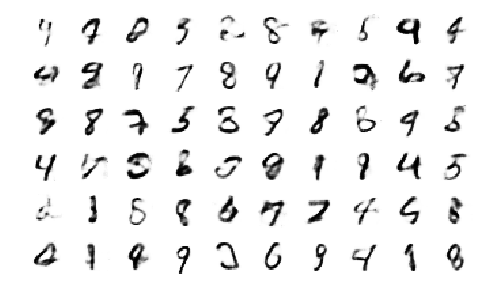

In [22]:
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

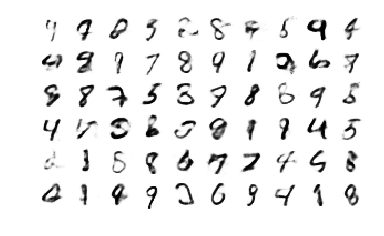

In [26]:

n_rows = 6
n_cols = 10
plot_multiple_image(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
plt.show()

# Encode and Decode

Encode

In [27]:
n_digits = 3
X_test,y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess,'E:/python_work/handson_ml/tf_logs/run_20170930_2/my_model_variational.ckpt')
    codings_val = codings.eval(feed_dict={X:X_test})

INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170930_2/my_model_variational.ckpt


Decode

In [28]:
with tf.Session() as sess:
    saver.restore(sess,'E:/python_work/handson_ml/tf_logs/run_20170930_2/my_model_variational.ckpt')
    outputs_val = outputs.eval(feed_dict={codings:codings_val})

INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170930_2/my_model_variational.ckpt


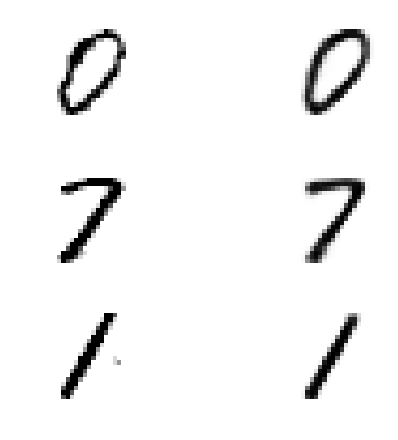

In [29]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

## Interpolate digits

INFO:tensorflow:Restoring parameters from E:/python_work/handson_ml/tf_logs/run_20170930_2/my_model_variational.ckpt


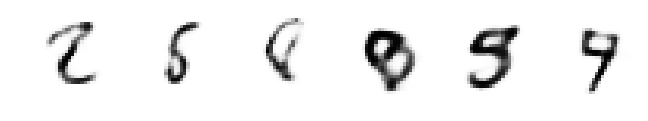

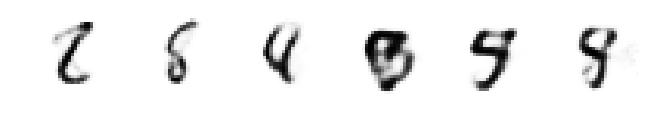

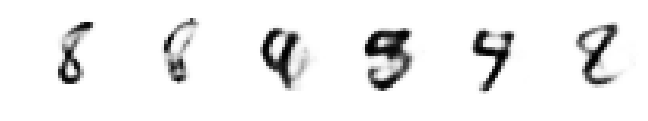

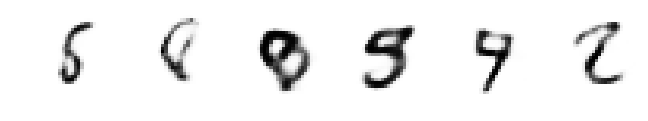

In [30]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits,n_hidden3])

n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "E:/python_work/handson_ml/tf_logs/run_20170930_2/my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()